# 雲天による遮光率のモデリング
- 雲は日光を遮る．衛星画像によって遮光率の値が分かっていると仮定しこれを統計モデルによって再現する．
    - 遮光率１：完全に雲
    - 遮光率０：晴天
- 1次元の疑似データを生成する
    - 混合数 3
    - ガウス分布の平均・分散パラメータ $\mu = \{2, 5, 8\} , \sigma^{2} = \{1, 1, 1\}$
    - 混合比 $\pi = \{0.3, 0.5, 0.2\}$
    - シグモイド係数　$a, b$ 
        - $\mathrm{sigmoid}(z) = \frac{1}{1+\exp{(-z)}}, z=ax +b$
    - 疑似データ $f(x) = u\left( \sum_{i} \pi_{i}\mathcal{N}(x ; \mu_{i}, \sigma_{i}^{2}) \right), u(x) = \mathrm{sigmoid(x)}$
- ガウス混合分布に対してシグモイド関数による変換を施すことで値を[0, 1]に収める
- 推定の設定
    - ガウス分布の混合数は既知とする
- 推定パラメータ
    - ガウス分布の平均・分散パラメータ　$ \mu, \sigma$
    - 混合比の重み $\pi$
- シグモイドの係数 $a, b$は別の方法で推定した方が良い？

In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
import itertools
from common.gradient import numerical_gradient
from common.optimizer import AdaGrad
from PIL import Image
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pdb
import time

from MakeData import TrueShade
from ShadeModel import ShadeModel
from misc import *


%matplotlib inline 

In [12]:
TrueModel = TrueShade()
Data = TrueModel.Generate()
Model = ShadeModel()

In [3]:
TrueModel.TrueParams

{'covs_fake': array([[ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.]]), 'move': array([[ 0.87811744,  0.02738759],
        [ 0.67046751,  0.4173048 ],
        [ 0.55868983,  0.14038694]]), 'mus': array([[  2.08511002e+00,   3.60162247e+00],
        [  5.71874087e-04,   1.51166286e+00],
        [  7.33779454e-01,   4.61692974e-01]]), 'pi': array([ 0.19294567,  0.12941616,  0.67763817])}

In [4]:
Model.params

{'covs_fake': array([[ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  1.]]), 'move': array([[ 0.17915741,  0.3634382 ],
        [ 0.11744566,  0.11511014],
        [ 0.05201143,  0.00774678],
        [ 0.27153421,  0.08465125],
        [ 0.10621866,  0.19662926],
        [ 0.02134502,  0.22964704],
        [ 0.05869143,  0.23572221],
        [ 0.27990334,  0.04093377],
        [ 0.1656224 ,  0.27776006],
        [ 0.16567171,  0.01998138]]), 'mus': array([[ 8.94606664,  0.85044211],
        [ 0.39054783,  1.6983042 ],
        [ 8.78142503,  0.98346834],
        [ 4.21107625,  9.5788953 ],
        [ 5.33165285,  6.91877114],
        [ 3.15515631,  6.86500928],
        [ 8.34625672,  0.18288277],
        [ 7.50144315,  9.88861089],
        [ 7.48165654, 

In [5]:
len(Data[0])

2500

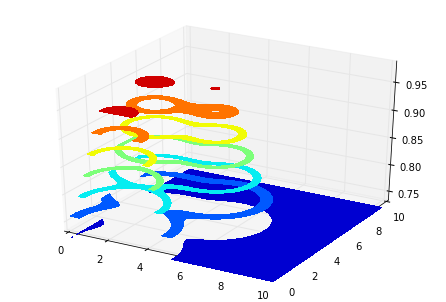

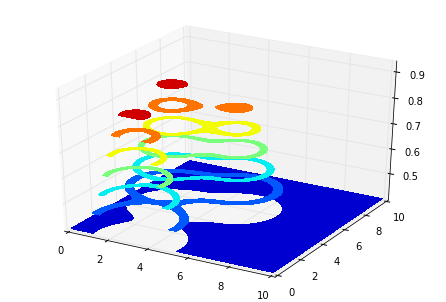

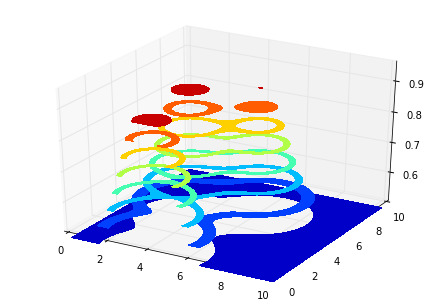

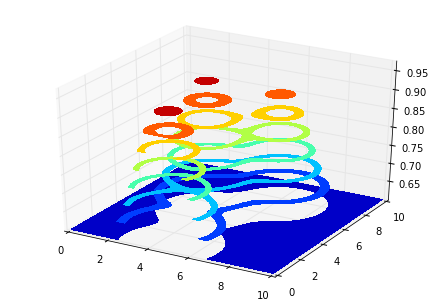

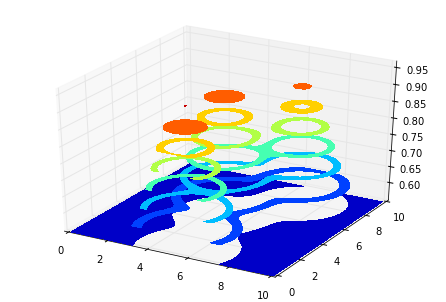

In [21]:
for f in TrueModel.frame:
    TrueModel.ShadePlot(frame_num=f,axtype='contourf')

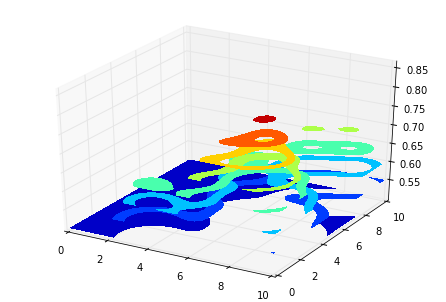

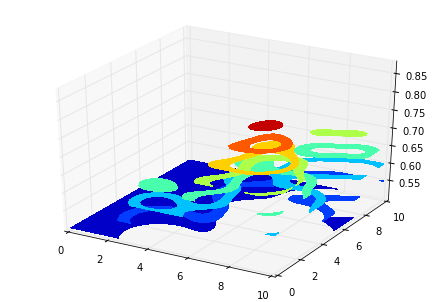

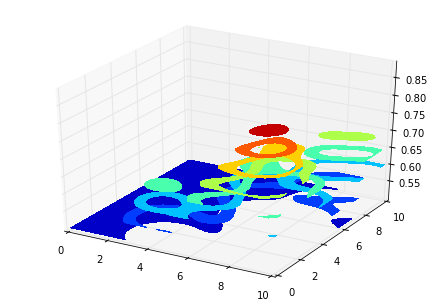

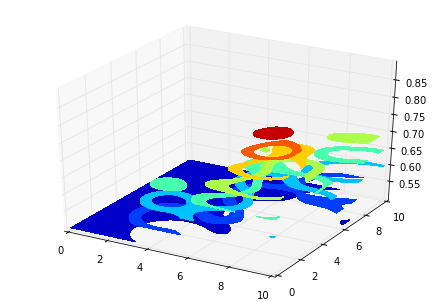

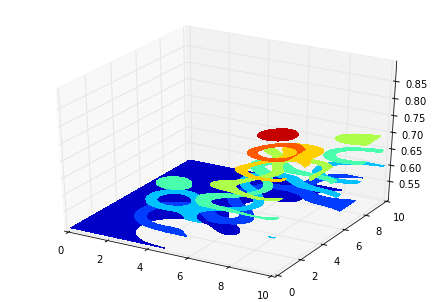

In [14]:
for f in Model.frame:
    Model.ModelPlot(frame=f, axtype='contourf')

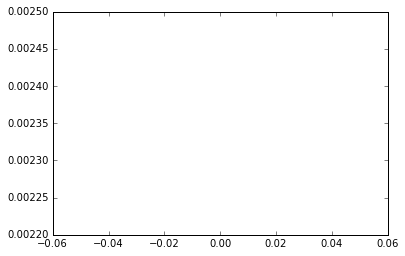

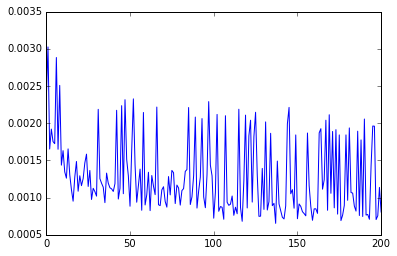

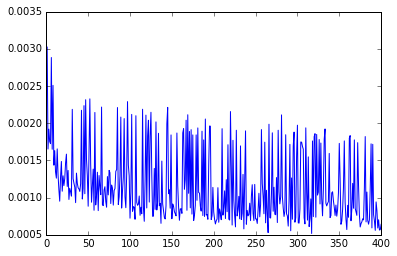

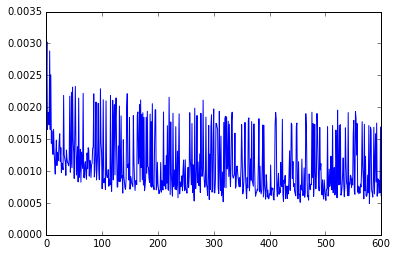

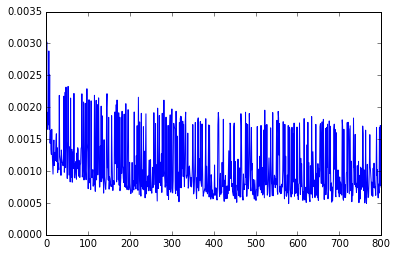

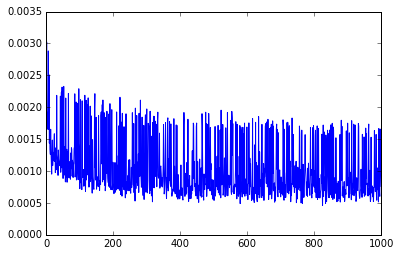

In [15]:
losslist = []

iterate = 1001

FrameSize = len(Data)
DataSize = len(Data[0])
BatchSize = 150
LearningRate = 0.1
epoch = 200
epsilon = 0.01

optimizer = AdaGrad()


for i in range(iterate):
    FrameSample = np.random.randint(FrameSize)
    
    batch_mask = np.random.choice(DataSize, BatchSize)
    DataBatch = Data[FrameSample][batch_mask]
    xBatch = Model.xy[batch_mask]
    
    grad = Model.Gradient(x = xBatch, frame=FrameSample, f=DataBatch)
    
    optimizer.update(params = Model.params, grads=grad)
        
    Model.params['pi'][Model.params['pi'] < epsilon] = epsilon
    Model.params['pi'] = Model.params['pi']/np.sum(Model.params['pi'])
        
    loss = Model.loss(x=xBatch, frame=FrameSample, f=DataBatch)
    losslist.append(loss)
        
    # pdb.set_trace()
        
    # print(str(i))
    if(i%epoch == 0):
        plt.plot(range(i+1), losslist)
        plt.show()
        


In [17]:
Model.params

{'covs_fake': array([[ 1.13581014,  0.02579378,  0.0360755 ,  0.96414077],
        [ 1.06157346,  0.00815911,  0.00421248,  1.00946991],
        [ 1.1535508 , -0.19130648, -0.16976539,  1.30674757],
        [ 1.07339045,  0.01676641,  0.01716547,  1.08979507],
        [ 1.52598033,  0.2212782 ,  0.30337837,  1.11086143],
        [ 1.0347805 , -0.00960547,  0.0129615 ,  1.16180453],
        [ 1.09140584, -0.04436153, -0.04616288,  1.07307901],
        [ 1.06384581, -0.02864164, -0.02700042,  1.11621072],
        [ 1.24562639, -0.09405195, -0.12207253,  1.04252985],
        [ 1.10562138, -0.13659879, -0.13760681,  1.10038542]]),
 'move': array([[ 0.20128117,  0.35243754],
        [ 0.2777281 ,  0.18593609],
        [ 0.23807202,  0.29082898],
        [ 0.01220318, -0.02621527],
        [-0.13696422,  0.13054191],
        [-0.02622427,  0.27224657],
        [ 0.23929453,  0.11360622],
        [ 0.21010527,  0.1995263 ],
        [ 0.10936085,  0.04375666],
        [ 0.24358487,  0.01603706

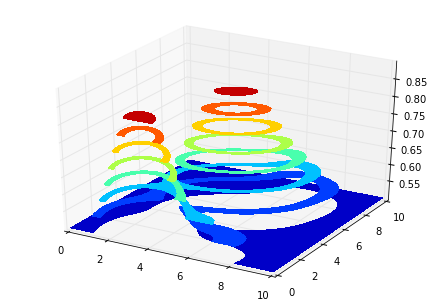

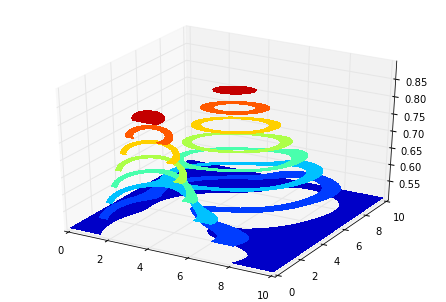

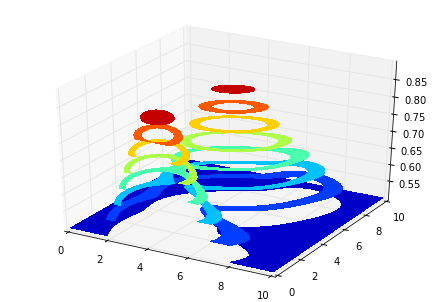

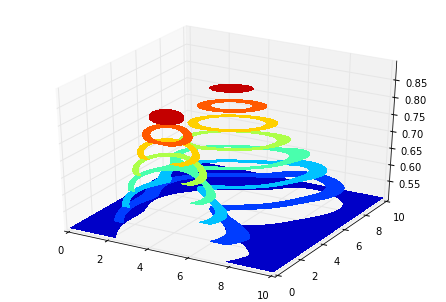

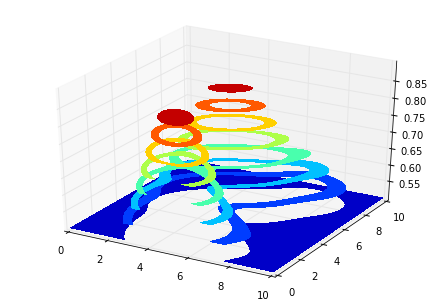

In [16]:
for f in Model.frame:
    Model.ModelPlot(frame=f, axtype='contourf')

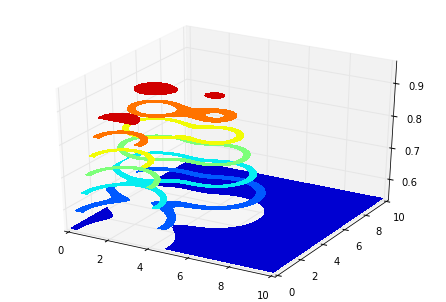

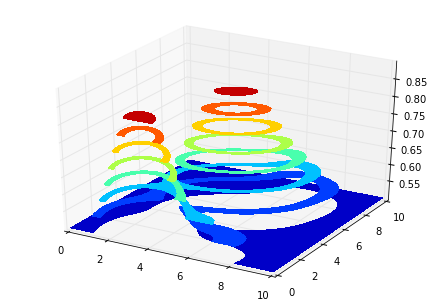

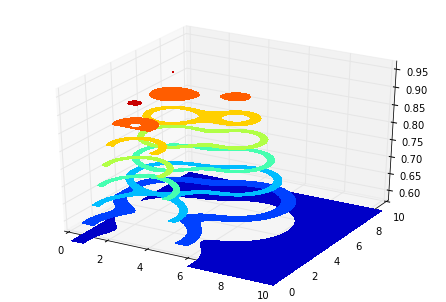

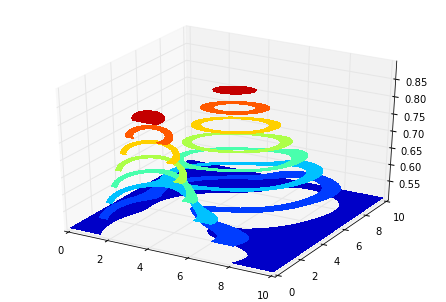

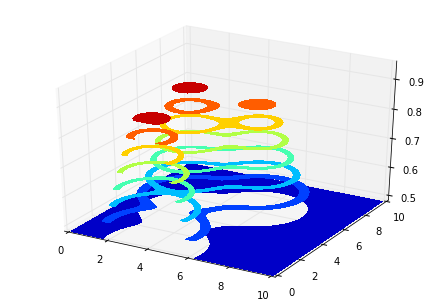

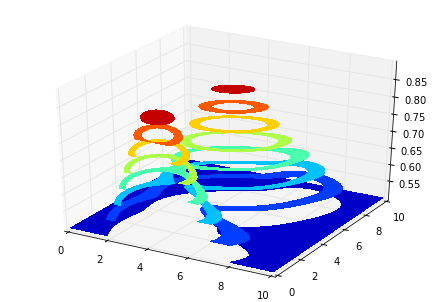

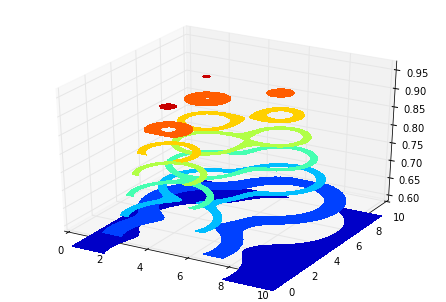

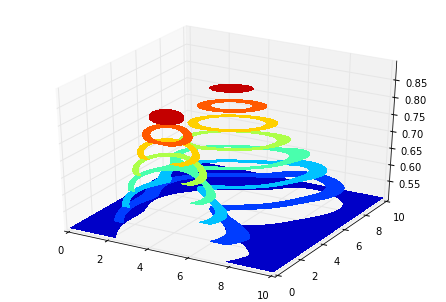

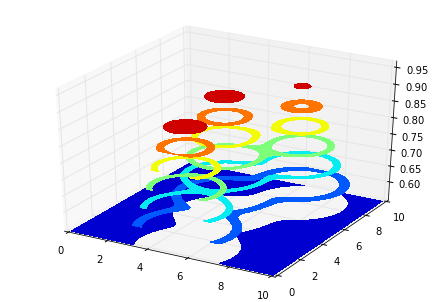

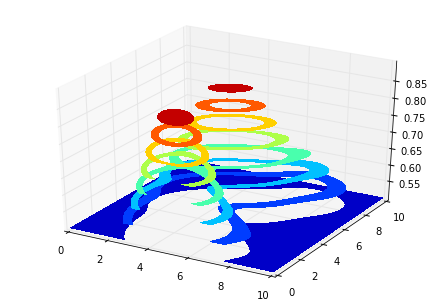

In [22]:
for f in range(5):
    fig = plt.figure()
    ax = Axes3D(fig)
    x = TrueModel.xy[:, 0]
    y = TrueModel.xy[:, 1]
    z = TrueModel.Generate()[f]
    xgrid = x.reshape(TrueModel.grid[0], TrueModel.grid[1])
    ygrid = y.reshape(TrueModel.grid[0], TrueModel.grid[1])
    zgrid = z.reshape(TrueModel.grid[0], TrueModel.grid[1])
    ax.contourf3D(xgrid, ygrid, zgrid)
    plt.savefig('data' + str(f)+'.png')
    
    fig = plt.figure()
    ax = Axes3D(fig)
    x = Model.xy[:, 0]
    y = Model.xy[:, 1]
    z = Model.predict(Model.xy, frame=f)
    xgrid = x.reshape(Model.grid[0], Model.grid[1])
    ygrid = y.reshape(Model.grid[0], Model.grid[1])
    zgrid = z.reshape(Model.grid[0], Model.grid[1])
    ax.contourf3D(xgrid, ygrid, zgrid)
    plt.savefig('result' + str(f)+'.png')
    

In [24]:
# plt.plot(range(len(losslist)), losslist)
len(losslist)

1001

In [40]:
! git add .
! git commit -m 'training'
! git push

[master dd9a6a5] training
 8 files changed, 1259 insertions(+), 753 deletions(-)
 create mode 100644 ShadingRatioModeling/.ipynb_checkpoints/ShadeTrain-checkpoint.ipynb
 rewrite ShadingRatioModeling/ShadeTrain.ipynb (83%)
 create mode 100644 ShadingRatioModeling/__pycache__/MakeData.cpython-35.pyc
 create mode 100644 ShadingRatioModeling/__pycache__/ShadeModel.cpython-35.pyc
 create mode 100644 ShadingRatioModeling/__pycache__/misc.cpython-35.pyc
Counting objects: 11, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (11/11), done.
Writing objects: 100% (11/11), 352.40 KiB | 0 bytes/s, done.
Total 11 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/daigo0927/pyworks
   cebf0f4..dd9a6a5  master -> master
